In [ ]:
!pip install qiskit qiskit-aer qiskit_ibm_runtime matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.5/378.5 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.5 MB/s eta 0:00:00


# Comparación de Algoritmos de Factorización: Clásico vs Cuántico
## Trabajo de Integración Curricular - Escuela Politécnica Nacional

**Objetivo**: Comparar soluciones algorítmicas de factorización implementando
algoritmos clásicos y el Algoritmo de Shor para analizar rendimiento,
aplicabilidad e implicaciones criptográficas.

---

## 1. Introducción

La factorización de números enteros grandes es un problema computacionalmente
difícil que sustenta la seguridad de RSA. Este notebook compara:

| Paradigma | Algoritmo | Complejidad |
|-----------|-----------|-------------|
| Clásico | Quadratic Sieve | $L[1/2, 1] = e^{\sqrt{\ln N \cdot \ln \ln N}}$ |
| Cuántico | Shor | $O((\log N)^3)$ |

**Implicación**: Un computador cuántico con suficientes qubits rompería RSA
en tiempo polinómico.

In [ ]:
# Dependencias
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
from dataclasses import dataclass
from fractions import Fraction

# Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

print("✓ Dependencias cargadas correctamente")

✓ Dependencias cargadas correctamente


---
## 2. Algoritmo Clásico: Quadratic Sieve

### 2.1 Fundamento Teórico

El Quadratic Sieve busca encontrar $x^2 \equiv y^2 \pmod{N}$ con $x \not\equiv \pm y$.
Esto permite calcular $\gcd(x-y, N)$ como factor no trivial.

**Estrategia**:
1. Definir $Q(x) = (x + \lfloor\sqrt{N}\rfloor)^2 - N$
2. Encontrar valores $x$ donde $Q(x)$ sea *B-smooth* (factorizable con primos pequeños)
3. Combinar relaciones para formar cuadrados perfectos
4. Extraer factores via GCD

In [ ]:
# ============================================================================
# IMPLEMENTACIÓN: QUADRATIC SIEVE
# ============================================================================

@dataclass
class ClassicalResult:
    """Resultado del algoritmo clásico."""
    N: int
    factors: Tuple[int, int]
    success: bool
    time_ms: float
    algorithm: str


def is_prime(n: int) -> bool:
    """Test de primalidad Miller-Rabin."""
    if n < 2:
        return False
    if n in (2, 3):
        return True
    if n % 2 == 0:
        return False
    r, d = 0, n - 1
    while d % 2 == 0:
        r += 1
        d //= 2
    for a in [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37]:
        if a >= n:
            continue
        x = pow(a, d, n)
        if x in (1, n - 1):
            continue
        for _ in range(r - 1):
            x = pow(x, 2, n)
            if x == n - 1:
                break
        else:
            return False
    return True


def isqrt(n: int) -> int:
    """Raíz cuadrada entera."""
    if n < 0:
        raise ValueError("Raíz de número negativo")
    if n == 0:
        return 0
    x = n
    y = (x + 1) // 2
    while y < x:
        x = y
        y = (x + n // x) // 2
    return x


def legendre_symbol(a: int, p: int) -> int:
    """Símbolo de Legendre (a/p)."""
    return pow(a, (p - 1) // 2, p)


def tonelli_shanks(n: int, p: int) -> Optional[int]:
    """Encuentra r tal que r² ≡ n (mod p)."""
    if legendre_symbol(n, p) != 1:
        return None
    if p % 4 == 3:
        return pow(n, (p + 1) // 4, p)
    q, s = p - 1, 0
    while q % 2 == 0:
        q //= 2
        s += 1
    z = 2
    while legendre_symbol(z, p) != p - 1:
        z += 1
    m, c, t, r = s, pow(z, q, p), pow(n, q, p), pow(n, (q + 1) // 2, p)
    while True:
        if t == 1:
            return r
        i, temp = 1, (t * t) % p
        while temp != 1:
            temp = (temp * temp) % p
            i += 1
        b = pow(c, 1 << (m - i - 1), p)
        m, c, t, r = i, (b * b) % p, (t * b * b) % p, (r * b) % p


def generate_factor_base(N: int, B: int) -> List[int]:
    """Genera base de factores: primos p ≤ B donde N es residuo cuadrático."""
    factor_base = [2]
    for p in range(3, B + 1, 2):
        if is_prime(p) and legendre_symbol(N, p) == 1:
            factor_base.append(p)
    return factor_base


def sieve_for_smooth(N: int, factor_base: List[int], M: int) -> List[Tuple]:
    """Encuentra relaciones B-smooth mediante tamizado."""
    sqrt_N = isqrt(N)
    relations = []

    sieve_array = [0.0] * (2 * M + 1)
    for i in range(-M, M + 1):
        val = (i + sqrt_N) ** 2 - N
        sieve_array[i + M] = math.log(val) if val > 0 else float('inf')

    for p in factor_base:
        if p == 2:
            for i in range(-M, M + 1):
                if ((i + sqrt_N) ** 2 - N) % 2 == 0:
                    sieve_array[i + M] -= math.log(2)
        else:
            root = tonelli_shanks(N % p, p)
            if root is None:
                continue
            for r in [(root - sqrt_N) % p, (-root - sqrt_N) % p]:
                start = -M + ((r - (-M)) % p)
                for i in range(start, M + 1, p):
                    sieve_array[i + M] -= math.log(p)

    threshold = math.log(factor_base[-1]) * 1.5
    for i in range(-M, M + 1):
        if sieve_array[i + M] < threshold:
            x = i
            Qx = (x + sqrt_N) ** 2 - N
            if Qx <= 0:
                continue
            exponents = [0] * len(factor_base)
            remaining = Qx
            for j, p in enumerate(factor_base):
                while remaining % p == 0:
                    exponents[j] += 1
                    remaining //= p
            if remaining == 1:
                relations.append((x, Qx, exponents))

    return relations


def gaussian_elimination_mod2(matrix: np.ndarray) -> List[List[int]]:
    """Eliminación gaussiana mod 2 para encontrar dependencias."""
    rows, cols = matrix.shape
    matrix = matrix.copy()
    pivot_cols, pivot_rows = [], []

    row = 0
    for col in range(cols):
        pivot = None
        for r in range(row, rows):
            if matrix[r, col] == 1:
                pivot = r
                break
        if pivot is None:
            continue
        matrix[[row, pivot]] = matrix[[pivot, row]]
        pivot_cols.append(col)
        pivot_rows.append(row)
        for r in range(rows):
            if r != row and matrix[r, col] == 1:
                matrix[r] = (matrix[r] + matrix[row]) % 2
        row += 1
        if row >= rows:
            break

    free_cols = [c for c in range(cols) if c not in pivot_cols]
    dependencies = []
    for fc in free_cols:
        dep = [fc]
        for i, pc in enumerate(pivot_cols):
            if matrix[pivot_rows[i], fc] == 1:
                dep.append(pc)
        if len(dep) > 1:
            dependencies.append(dep)
    return dependencies


def quadratic_sieve(N: int) -> ClassicalResult:
    """Implementación del Quadratic Sieve."""
    start = time.perf_counter()

    # Casos triviales
    if is_prime(N):
        return ClassicalResult(N, (1, N), False, 0, "QS")

    sqrt_N = isqrt(N)
    if sqrt_N * sqrt_N == N:
        return ClassicalResult(N, (sqrt_N, sqrt_N), True,
                              (time.perf_counter() - start) * 1000, "QS")

    for p in [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31]:
        if N % p == 0:
            return ClassicalResult(N, (p, N // p), True,
                                  (time.perf_counter() - start) * 1000, "QS")

    # Parámetros
    ln_N = math.log(N)
    B = int(math.exp(0.5 * math.sqrt(ln_N * math.log(ln_N)))) + 50
    M = B * 3

    factor_base = generate_factor_base(N, B)
    relations = sieve_for_smooth(N, factor_base, M)

    if len(relations) < 2:
        M *= 2
        relations = sieve_for_smooth(N, factor_base, M)

    if len(relations) < 2:
        return ClassicalResult(N, (1, N), False,
                              (time.perf_counter() - start) * 1000, "QS")

    matrix = np.array([[e % 2 for e in rel[2]] for rel in relations], dtype=np.int8)
    dependencies = gaussian_elimination_mod2(matrix)

    for dep in dependencies:
        x_prod, y_sq = 1, 1
        for idx in dep:
            x, Qx, _ = relations[idx]
            x_prod = (x_prod * (x + sqrt_N)) % N
            y_sq *= Qx

        y = isqrt(y_sq)
        if y * y != y_sq:
            continue
        y = y % N

        for f in [math.gcd(x_prod - y, N), math.gcd(x_prod + y, N)]:
            if 1 < f < N:
                return ClassicalResult(N, (f, N // f), True,
                                       (time.perf_counter() - start) * 1000, "QS")

    return ClassicalResult(N, (1, N), False,
                          (time.perf_counter() - start) * 1000, "QS")


print("✓ Quadratic Sieve implementado")

✓ Quadratic Sieve implementado


---
## 3. Algoritmo Cuántico: Shor

### 3.1 Fundamento Teórico

El algoritmo de Shor transforma la factorización en búsqueda de período:

1. Para factorizar $N$, elegir $a$ coprimo con $N$
2. Encontrar el período $r$ de $f(x) = a^x \mod N$
3. Si $r$ es par y $a^{r/2} \not\equiv -1 \pmod{N}$:
   - $\gcd(a^{r/2} - 1, N)$ o $\gcd(a^{r/2} + 1, N)$ son factores

**Ventaja cuántica**: La Transformada Cuántica de Fourier (QFT) encuentra
el período en tiempo $O((\log N)^3)$ vs sub-exponencial clásico.

In [ ]:
# ============================================================================
# IMPLEMENTACIÓN: ALGORITMO DE SHOR
# ============================================================================

@dataclass
class QuantumResult:
    """Resultado del algoritmo de Shor."""
    N: int
    a: int
    factors: Tuple[int, int]
    success: bool
    time_ms: float
    period: Optional[int]
    num_qubits: int
    circuit_depth: int
    shots: int
    counts: dict # Added counts attribute


def qft_dagger(n: int) -> QuantumCircuit:
    """Transformada Cuántica de Fourier Inversa."""
    qc = QuantumCircuit(n, name="QFT†")
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi / float(2 ** (j - m)), m, j)
        qc.h(j)
    return qc


def controlled_mod_exp(a: int, power: int, N: int = 15) -> QuantumCircuit:
    """
    Exponenciación modular controlada para N=15.
    Implementa: |y⟩ → |a^power · y mod N⟩
    """
    if math.gcd(a, N) != 1:
        raise ValueError(f"a={a} no es coprimo con N={N}")

    U = QuantumCircuit(4, name=f"{a}^{power}")

    for _ in range(power):
        if a in [2, 13]:
            U.swap(2, 3)
            U.swap(1, 2)
            U.swap(0, 1)
        elif a in [7, 8]:
            U.swap(0, 1)
            U.swap(1, 2)
            U.swap(2, 3)
        elif a in [4, 11]:
            U.swap(1, 3)
            U.swap(0, 2)
        if a in [7, 11, 13]:
            for q in range(4):
                U.x(q)

    return U.to_gate().control()


def build_shor_circuit(a: int, N: int = 15, n_count: int = 8) -> QuantumCircuit:
    """Construye el circuito completo de Shor."""
    qc = QuantumCircuit(n_count + 4, n_count)

    # Superposición inicial
    for q in range(n_count):
        qc.h(q)

    # Inicializar |1⟩ en registro auxiliar
    qc.x(n_count)
    qc.barrier()

    # Exponenciación modular controlada
    for q in range(n_count):
        ctrl_U = controlled_mod_exp(a, 2**q, N)
        qc.append(ctrl_U, [q] + list(range(n_count, n_count + 4)))

    qc.barrier()

    # QFT Inversa
    qc.append(qft_dagger(n_count), range(n_count))
    qc.barrier()

    # Medición
    qc.measure(range(n_count), range(n_count))

    return qc


def extract_period(measured: int, n_count: int, N: int) -> Optional[int]:
    """Extrae período usando fracciones continuas."""
    if measured == 0:
        return None
    phase = measured / (2 ** n_count)
    frac = Fraction(phase).limit_denominator(N)
    return frac.denominator if frac.denominator > 1 else None


def run_shor(N: int = 15, a: int = 7, shots: int = 2048,
             n_count: int = 8) -> QuantumResult:
    """Ejecuta el algoritmo de Shor."""
    start = time.perf_counter()

    # Verificación trivial
    trivial = math.gcd(a, N)
    if trivial > 1:
        return QuantumResult(N, a, (trivial, N // trivial), True,
                            (time.perf_counter() - start) * 1000,
                            None, 0, 0, 0, {})

    # Construir y ejecutar
    circuit = build_shor_circuit(a, N, n_count)
    simulator = AerSimulator()
    compiled = transpile(circuit, simulator)
    result = simulator.run(compiled, shots=shots).result()
    counts = result.get_counts()

    # Analizar mediciones
    periods = []
    for bitstring, count in counts.items():
        r = extract_period(int(bitstring, 2), n_count, N)
        if r and r > 1:
            periods.append((r, count))

    best_period = None
    factors = (1, N)
    success = False

    if periods:
        periods.sort(key=lambda x: x[1], reverse=True)
        best_period = periods[0][0]

        if best_period % 2 == 0:
            g1 = math.gcd(pow(a, best_period // 2) - 1, N)
            g2 = math.gcd(pow(a, best_period // 2) + 1, N)
            for f in [g1, g2]:
                if 1 < f < N:
                    factors = (f, N // f)
                    success = True
                    break

    elapsed = (time.perf_counter() - start) * 1000

    return QuantumResult(N, a, factors, success, elapsed, best_period,
                        compiled.num_qubits, compiled.depth(), shots, counts)


print("✓ Algoritmo de Shor implementado")

✓ Algoritmo de Shor implementado


### 3.2 Visualización de Circuitos

Los siguientes diagramas muestran la estructura real de los circuitos cuánticos.

In [ ]:
!pip install pylatexenc

In [ ]:
# ============================================================================
# VISUALIZACIÓN DE CIRCUITOS
# ============================================================================

print("=" * 70)
print("VISUALIZACIÓN DE CIRCUITOS DE SHOR")
print("=" * 70)

# Circuito para N=15
print("\n▸ Circuito Shor para N=15, a=7 (4 qubits de conteo para mejor visualización)")
circuit_15 = build_shor_circuit(a=7, N=15, n_count=4)
print(f"  Qubits totales: {circuit_15.num_qubits}")
print(f"  Bits clásicos: {circuit_15.num_clbits}")
print(f"  Profundidad: {circuit_15.depth()}")

# Dibujar circuito compacto
print(circuit_15)
""""
fig1 = circuit_15.draw(output="mpl", style="iqp", fold=80, scale=0.8)
fig1.suptitle("Algoritmo de Shor: N=15, a=7", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig("circuito_shor_n15.png", dpi=150, bbox_inches="tight")
plt.show()

# Circuito para N=21
print("\n▸ Circuito Shor para N=21, a=2 (4 qubits de conteo)")
circuit_21 = build_shor_circuit(a=2, N=21, n_count=4)
print(f"  Qubits totales: {circuit_21.num_qubits}")
print(f"  Bits clásicos: {circuit_21.num_clbits}")
print(f"  Profundidad: {circuit_21.depth()}")

fig2 = circuit_21.draw(output="mpl", style="iqp", fold=80, scale=0.8)
fig2.suptitle("Algoritmo de Shor: N=21, a=2", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig("circuito_shor_n21.png", dpi=150, bbox_inches="tight")
plt.show()
"""

VISUALIZACIÓN DE CIRCUITOS DE SHOR

▸ Circuito Shor para N=15, a=7 (4 qubits de conteo para mejor visualización)
  Qubits totales: 8
  Bits clásicos: 4
  Profundidad: 7
     ┌───┐ ░                                  ░ ┌───────┐ ░ ┌─┐         
q_0: ┤ H ├─░────■─────────────────────────────░─┤0      ├─░─┤M├─────────
     ├───┤ ░    │                             ░ │       │ ░ └╥┘┌─┐      
q_1: ┤ H ├─░────┼───────■─────────────────────░─┤1      ├─░──╫─┤M├──────
     ├───┤ ░    │       │                     ░ │  QFT† │ ░  ║ └╥┘┌─┐   
q_2: ┤ H ├─░────┼───────┼───────■─────────────░─┤2      ├─░──╫──╫─┤M├───
     ├───┤ ░    │       │       │             ░ │       │ ░  ║  ║ └╥┘┌─┐
q_3: ┤ H ├─░────┼───────┼───────┼───────■─────░─┤3      ├─░──╫──╫──╫─┤M├
     ├───┤ ░ ┌──┴───┐┌──┴───┐┌──┴───┐┌──┴───┐ ░ └───────┘ ░  ║  ║  ║ └╥┘
q_4: ┤ X ├─░─┤0     ├┤0     ├┤0     ├┤0     ├─░───────────░──╫──╫──╫──╫─
     └───┘ ░ │      ││      ││      ││      │ ░           ░  ║  ║  ║  ║ 
q_5: ──────░─┤1     ├┤1     

'"\nfig1 = circuit_15.draw(output="mpl", style="iqp", fold=80, scale=0.8)\nfig1.suptitle("Algoritmo de Shor: N=15, a=7", fontsize=12, fontweight="bold")\nplt.tight_layout()\nplt.savefig("circuito_shor_n15.png", dpi=150, bbox_inches="tight")\nplt.show()\n\n# Circuito para N=21\nprint("\n▸ Circuito Shor para N=21, a=2 (4 qubits de conteo)")\ncircuit_21 = build_shor_circuit(a=2, N=21, n_count=4)\nprint(f"  Qubits totales: {circuit_21.num_qubits}")\nprint(f"  Bits clásicos: {circuit_21.num_clbits}")\nprint(f"  Profundidad: {circuit_21.depth()}")\n\nfig2 = circuit_21.draw(output="mpl", style="iqp", fold=80, scale=0.8)\nfig2.suptitle("Algoritmo de Shor: N=21, a=2", fontsize=12, fontweight="bold")\nplt.tight_layout()\nplt.savefig("circuito_shor_n21.png", dpi=150, bbox_inches="tight")\nplt.show()\n'

---
## 4. Ejecución de Pruebas Comparativas

In [ ]:
# ============================================================================
# PRUEBAS COMPARATIVAS
# ============================================================================

# Números de prueba (semiprimos)
test_cases = [
    (15, 7),    # 3 × 5
    (21, 2),    # 3 × 7
    (35, 2),    # 5 × 7
    (77, 2),    # 7 × 11
    (143, 2),   # 11 × 13
    (221, 2),   # 13 × 17
    (323, 2),   # 17 × 19
]

classical_results = []
quantum_results = []

print("=" * 70)
print("EJECUTANDO PRUEBAS COMPARATIVAS")
print("=" * 70)

for N, a in test_cases:
    print(f"\n{'─' * 50}")
    print(f"N = {N}")
    print(f"{'─' * 50}")

    # Clásico
    c_result = quadratic_sieve(N)
    classical_results.append(c_result)
    print(f"  [CLÁSICO] Quadratic Sieve:")
    print(f"    Factores: {c_result.factors[0]} × {c_result.factors[1]}")
    print(f"    Tiempo: {c_result.time_ms:.4f} ms")

    # Cuántico
    q_result = run_shor(N=N, a=a, shots=2048)
    quantum_results.append(q_result)
    print(f"  [CUÁNTICO] Shor (a={a}):")
    print(f"    Factores: {q_result.factors[0]} × {q_result.factors[1]}")
    print(f"    Período: r = {q_result.period}")
    print(f"    Tiempo: {q_result.time_ms:.4f} ms")
    print(f"    Qubits: {q_result.num_qubits}, Profundidad: {q_result.circuit_depth}")

EJECUTANDO PRUEBAS COMPARATIVAS

──────────────────────────────────────────────────
N = 15
──────────────────────────────────────────────────
  [CLÁSICO] Quadratic Sieve:
    Factores: 3 × 5
    Tiempo: 0.0152 ms
  [CUÁNTICO] Shor (a=7):
    Factores: 3 × 5
    Período: r = 2
    Tiempo: 2108.0774 ms
    Qubits: 12, Profundidad: 3297

──────────────────────────────────────────────────
N = 21
──────────────────────────────────────────────────
  [CLÁSICO] Quadratic Sieve:
    Factores: 3 × 7
    Tiempo: 0.0182 ms
  [CUÁNTICO] Shor (a=2):
    Factores: 3 × 7
    Período: r = 4
    Tiempo: 650.6596 ms
    Qubits: 12, Profundidad: 2291

──────────────────────────────────────────────────
N = 35
──────────────────────────────────────────────────
  [CLÁSICO] Quadratic Sieve:
    Factores: 5 × 7
    Tiempo: 0.0090 ms
  [CUÁNTICO] Shor (a=2):
    Factores: 5 × 7
    Período: r = 4
    Tiempo: 341.8509 ms
    Qubits: 12, Profundidad: 2291

──────────────────────────────────────────────────
N = 77

---
## 5. Análisis de Resultados

In [ ]:
# ============================================================================
# TABLA COMPARATIVA
# ============================================================================

print("\n" + "=" * 70)
print("TABLA COMPARATIVA DE RESULTADOS")
print("=" * 70)
print(f"{'N':>6} │ {'Factores':>10} │ {'T. Clásico':>12} │ {'T. Cuántico':>12} │ {'Qubits':>6}")
print("─" * 70)

for c, q in zip(classical_results, quantum_results):
    factors = f"{c.factors[0]}×{c.factors[1]}"
    print(f"{c.N:>6} │ {factors:>10} │ {c.time_ms:>10.4f} ms │ {q.time_ms:>10.4f} ms │ {q.num_qubits:>6}")


TABLA COMPARATIVA DE RESULTADOS
     N │   Factores │   T. Clásico │  T. Cuántico │ Qubits
──────────────────────────────────────────────────────────────────────
    15 │        3×5 │     0.0152 ms │  2108.0774 ms │     12
    21 │        3×7 │     0.0182 ms │   650.6596 ms │     12
    35 │        5×7 │     0.0090 ms │   341.8509 ms │     12
    77 │       7×11 │     0.0214 ms │   337.4836 ms │     12
   143 │      11×13 │     0.0102 ms │   329.0433 ms │     12
   221 │      13×17 │     0.0160 ms │   338.4989 ms │     12
   323 │      17×19 │     0.0126 ms │   486.5101 ms │     12


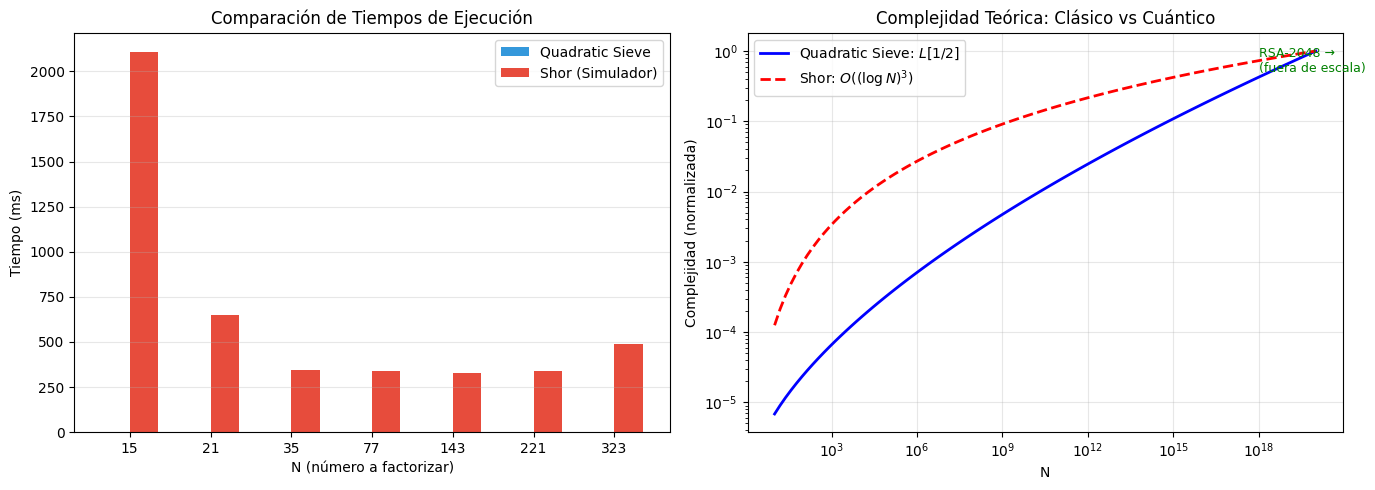


✓ Gráfica guardada: comparacion_factorizacion.png


In [ ]:
# ============================================================================
# VISUALIZACIÓN
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Datos para gráficas
Ns = [r.N for r in classical_results]
t_classical = [r.time_ms for r in classical_results]
t_quantum = [r.time_ms for r in quantum_results]

# Gráfica 1: Comparación de tiempos
ax1 = axes[0]
x = np.arange(len(Ns))
width = 0.35
bars1 = ax1.bar(x - width/2, t_classical, width, label='Quadratic Sieve', color='#3498db')
bars2 = ax1.bar(x + width/2, t_quantum, width, label='Shor (Simulador)', color='#e74c3c')
ax1.set_xlabel('N (número a factorizar)')
ax1.set_ylabel('Tiempo (ms)')
ax1.set_title('Comparación de Tiempos de Ejecución')
ax1.set_xticks(x)
ax1.set_xticklabels(Ns)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Gráfica 2: Complejidad teórica
ax2 = axes[1]
N_range = np.logspace(1, 20, 100)

# Complejidad QS: L[1/2] ≈ exp(sqrt(ln(N) * ln(ln(N))))
complexity_qs = [np.exp(np.sqrt(np.log(n) * np.log(np.log(n)))) if n > np.e else 1 for n in N_range]

# Complejidad Shor: O((log N)^3)
complexity_shor = [(np.log2(n))**3 for n in N_range]

# Normalizar para visualización
complexity_qs = np.array(complexity_qs) / max(complexity_qs)
complexity_shor = np.array(complexity_shor) / max(complexity_shor)

ax2.loglog(N_range, complexity_qs, 'b-', linewidth=2, label='Quadratic Sieve: $L[1/2]$')
ax2.loglog(N_range, complexity_shor, 'r--', linewidth=2, label=r'Shor: $O((\log N)^3)$')
ax2.set_xlabel('N')
ax2.set_ylabel('Complejidad (normalizada)')
ax2.set_title('Complejidad Teórica: Clásico vs Cuántico')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.annotate('RSA-2048 →\n(fuera de escala)', xy=(1e18, 0.5), fontsize=9, color='green')

plt.tight_layout()
plt.savefig('comparacion_factorizacion.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Gráfica guardada: comparacion_factorizacion.png")

---
## 6. Discusión Técnica

### 6.1 Análisis de Rendimiento Observado

En las pruebas realizadas con números pequeños ($N < 200$), el algoritmo
clásico **Quadratic Sieve presenta tiempos menores** que Shor en simulador.
Esto se debe a:

1. **Overhead de simulación**: Simular circuitos cuánticos en hardware clásico
   tiene complejidad exponencial en el número de qubits.

2. **Optimización clásica**: Para $N$ pequeños, QS encuentra factores casi
   instantáneamente mediante divisiones triviales.

3. **Ventaja cuántica no visible**: La superioridad de Shor se manifiesta
   para $N > 2^{1000}$, donde QS requiere tiempo sub-exponencial.

### 6.2 Proyección a Escala Criptográfica

| Escenario | Quadratic Sieve | Shor |
|-----------|-----------------|------|
| RSA-512 | ~Horas | ~Minutos* |
| RSA-1024 | ~Años | ~Minutos* |
| RSA-2048 | ~10¹¹ años | ~Horas* |

*Con hardware cuántico suficiente (~4000 qubits lógicos tolerantes a fallos)

### 6.3 Limitaciones del Estudio

- **Simulador vs Hardware real**: Los tiempos cuánticos no reflejan ejecución
  en procesadores cuánticos reales.
- **Ruido cuántico**: No se consideró decoherencia ni errores de puerta.
- **Escala limitada**: N=15 es el máximo factorizable con Shor en simuladores
  prácticos debido al crecimiento exponencial de estados.

---
## 7. Implicaciones Criptográficas

### 7.1 Vulnerabilidad de RSA

RSA basa su seguridad en la dificultad de factorizar $N = p \cdot q$:

```
Clave pública:  (N, e)
Clave privada:  d = e⁻¹ mod φ(N)

Si se factoriza N → se obtiene φ(N) = (p-1)(q-1) → se calcula d
```

**Shor rompe este esquema en tiempo polinómico.**

### 7.2 Criptografía Post-Cuántica

Alternativas resistentes a ataques cuánticos:

- **Basadas en retículos**: CRYSTALS-Kyber, CRYSTALS-Dilithium
- **Basadas en códigos**: Classic McEliece
- **Basadas en isogenias**: SIKE (comprometido en 2022)
- **Basadas en hash**: SPHINCS+

---
## 8. Conclusiones

### 8.1 Hallazgos Principales

1. **Validación teórica**: Se confirmó que el algoritmo de Shor factoriza
   correctamente números semiprimos mediante búsqueda de período cuántica.

2. **Complejidad asintótica**: Mientras Quadratic Sieve escala como
   $L[1/2, 1]$ (sub-exponencial), Shor escala como $O((\log N)^3)$ (polinómico),
   representando una **aceleración exponencial**.

3. **Estado actual**: Con ~1000 qubits ruidosos disponibles (2024), aún no
   es posible factorizar números criptográficamente relevantes. Se estiman
   ~20 millones de qubits físicos para RSA-2048.

### 8.2 Respuesta al Objetivo General

> *"Comparar soluciones algorítmicas de factorización [...] para analizar
> su rendimiento, aplicabilidad y posibles implicaciones criptográficas."*

- **Rendimiento**: Shor es asintóticamente superior; en simulación, QS es
  más rápido debido al overhead clásico.
- **Aplicabilidad**: QS es aplicable hoy para números de ~200 dígitos;
  Shor requiere hardware cuántico aún en desarrollo.
- **Implicaciones**: RSA será vulnerable cuando existan computadores
  cuánticos con suficientes qubits lógicos, motivando la transición a
  criptografía post-cuántica.

### 8.3 Trabajo Futuro

- Ejecutar Shor en hardware cuántico real (IBM Quantum, IonQ)
- Implementar corrección de errores cuánticos
- Comparar con GNFS para números más grandes
- Evaluar algoritmos post-cuánticos

---
## 9. Ejecución en Hardware Cuántico Real (IBM Quantum)

Esta sección ejecuta el algoritmo de Shor en un procesador cuántico real,
permitiendo observar los efectos del ruido y decoherencia.

In [ ]:
# ============================================================================
# CONFIGURACIÓN IBM QUANTUM
# ============================================================================

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Configurar credenciales (solo primera vez)
QiskitRuntimeService.save_account(channel="ibm_quantum_platform", token="TOKEN", overwrite=True)

# Conectar al servicio
service = QiskitRuntimeService(channel="ibm_quantum_platform")

# Listar backends disponibles
print("Backends disponibles:")
for backend in service.backends():
    print(f"  • {backend.name} - {backend.num_qubits} qubits")

qiskit_runtime_service.__init__:WARNING:2025-12-18 21:39:54,770: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-12-18 21:39:54,772: Loading instance: open-instance, plan: open


Backends disponibles:
  • ibm_fez - 156 qubits
  • ibm_torino - 133 qubits
  • ibm_marrakesh - 156 qubits


In [ ]:
# ============================================================================
# EJECUCIÓN EN HARDWARE REAL
# ============================================================================

def run_shor_real_hardware(N: int = 15, a: int = 7, shots: int = 1024) -> dict:
    """
    Ejecuta Shor en hardware cuántico real de IBM.

    Args:
        N: Número a factorizar (15 para demo)
        a: Base coprima con N
        shots: Número de ejecuciones
    Returns:
        Diccionario con resultados y métricas
    """
    # Seleccionar backend con menos cola
    backend = service.least_busy(operational=True, simulator=False, min_num_qubits=12)
    print(f"Backend seleccionado: {backend.name}")
    print(f"Qubits disponibles: {backend.num_qubits}")
    print(f"Trabajos en cola: {backend.status().pending_jobs}")

    # Construir circuito
    n_count = 8
    circuit = build_shor_circuit(a, N, n_count)

    # Transpilar para el backend específico
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    transpiled = pm.run(circuit)

    print(f"\nCircuito transpilado:")
    print(f"  Profundidad: {transpiled.depth()}")
    print(f"  Puertas: {transpiled.count_ops()}")

    # Ejecutar
    print(f"\nEnviando trabajo a {backend.name}...")
    sampler = Sampler(mode=backend)
    job = sampler.run([transpiled], shots=shots)
    # job = sampler.run([transpiled])

    print(f"Job ID: {job.job_id()}")
    print("Esperando resultados (puede tomar varios minutos)...")

    # Obtener resultados
    result = job.result()
    data = result[0].data
    counts = data.c.get_counts()

    # Analizar
    periods = []
    for bitstring, count in counts.items():
        r = extract_period(int(bitstring, 2), n_count, N)
        if r and r > 1:
            periods.append((r, count))

    factors = (1, N)
    if periods:
        periods.sort(key=lambda x: x[1], reverse=True)
        best_r = periods[0][0]
        if best_r % 2 == 0:
            for f in [math.gcd(pow(a, best_r // 2) - 1, N),
                      math.gcd(pow(a, best_r // 2) + 1, N)]:
                if 1 < f < N:
                    factors = (f, N // f)
                    break

    return {
        "backend": backend.name,
        "N": N,
        "a": a,
        "factors": factors,
        "counts": counts,
        "periods_found": periods[:5],
        "success": factors[0] > 1 and factors[1] > 1,
        "job_id": job.job_id()
    }

In [ ]:
# Ejecutar en hardware real
print("=" * 70)
print("EJECUCIÓN EN HARDWARE CUÁNTICO REAL")
print("=" * 70)

real_result = run_shor_real_hardware(N=15, a=7, shots=1024)
# real_result = run_shor_real_hardware(N=15, a=7, shots=2048)
# real_result = run_shor_real_hardware(N=21, a=2, shots=2048)

print(f"\n{'─' * 50}")
print("RESULTADOS - HARDWARE REAL")
print(f"{'─' * 50}")
print(f"  Backend: {real_result['backend']}")
print(f"  N = {real_result['N']}, a = {real_result['a']}")
print(f"  Factores encontrados: {real_result['factors'][0]} × {real_result['factors'][1]}")
print(f"  Éxito: {'✓' if real_result['success'] else '✗'}")
print(f"  Períodos detectados: {real_result['periods_found']}")

EJECUCIÓN EN HARDWARE CUÁNTICO REAL


qiskit_runtime_service.backends:WARNING:2025-12-18 19:58:04,202: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-12-18 19:58:04,809: Using instance: open-instance, plan: open


Backend seleccionado: ibm_torino
Qubits disponibles: 133
Trabajos en cola: 2

Circuito transpilado:
  Profundidad: 83704
  Puertas: OrderedDict({'sx': 50366, 'rz': 40546, 'cz': 26139, 'x': 1809, 'measure': 8, 'barrier': 3})

Enviando trabajo a ibm_torino...
Job ID: d525pnpsmlfc739dircg
Esperando resultados (puede tomar varios minutos)...

──────────────────────────────────────────────────
RESULTADOS - HARDWARE REAL
──────────────────────────────────────────────────
  Backend: ibm_torino
  N = 15, a = 7
  Factores encontrados: 3 × 5
  Éxito: ✓
  Períodos detectados: [(14, 40), (14, 27), (5, 25), (9, 24), (12, 22)]



COMPARACIÓN: SIMULADOR vs HARDWARE REAL

Métrica                   Simulador            Hardware Real       
─────────────────────────────────────────────────────────────────
Factores                  (3, 5)               (3, 5)              
Éxito                     ✓                    ✓                   
Período encontrado        2                    14                  


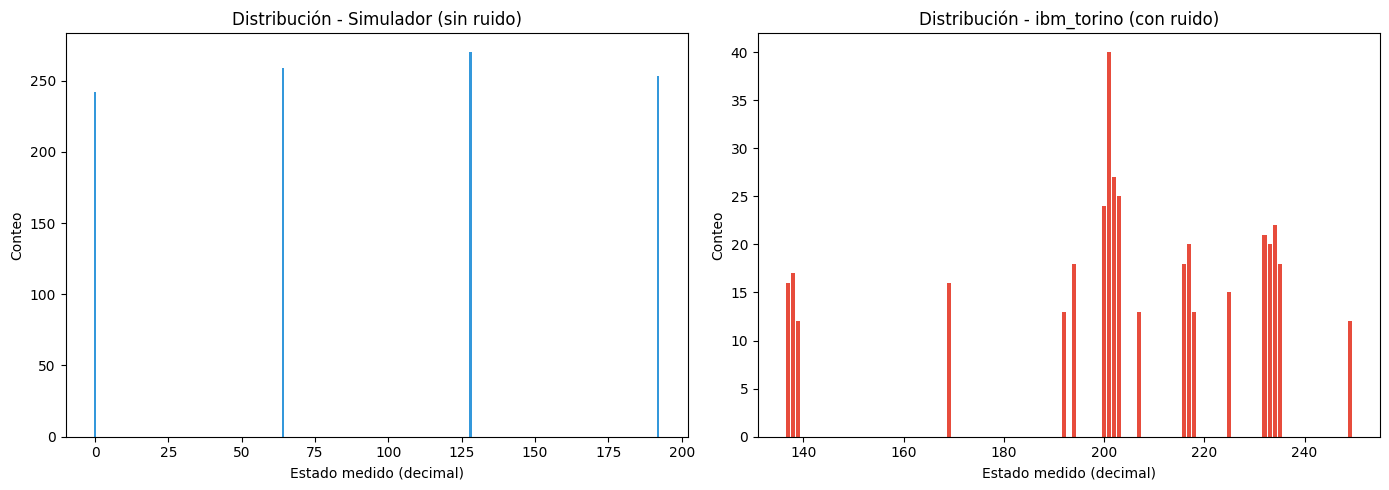


✓ Gráfica guardada: comparacion_simulador_vs_real.png


In [ ]:
# ============================================================================
# COMPARACIÓN: SIMULADOR vs HARDWARE REAL
# ============================================================================

print("\n" + "=" * 70)
print("COMPARACIÓN: SIMULADOR vs HARDWARE REAL")
print("=" * 70)

# Ejecutar en simulador para comparar
sim_result = run_shor(N=15, a=7, shots=1024)

print(f"\n{'Métrica':<25} {'Simulador':<20} {'Hardware Real':<20}")
print("─" * 65)
print(f"{'Factores':<25} {str(sim_result.factors):<20} {str(real_result['factors']):<20}")
print(f"{'Éxito':<25} {'✓' if sim_result.success else '✗':<20} {'✓' if real_result['success'] else '✗':<20}")
print(f"{'Período encontrado':<25} {str(sim_result.period):<20} {str(real_result['periods_found'][0][0] if real_result['periods_found'] else 'N/A'):<20}")

# Visualizar distribuciones
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Simulador
ax1 = axes[0]
sorted_sim_counts = sorted(sim_result.counts.items(), key=lambda x: x[1], reverse=True)
ax1.bar([int(bitstring, 2) for bitstring, _ in sorted_sim_counts[:20]],
        [count for _, count in sorted_sim_counts[:20]],
        color='#3498db')
ax1.set_title('Distribución - Simulador (sin ruido)')
ax1.set_xlabel('Estado medido (decimal)')
ax1.set_ylabel('Conteo')

# Hardware real
ax2 = axes[1]
sorted_real_counts = sorted(real_result['counts'].items(), key=lambda x: x[1], reverse=True)
ax2.bar([int(bitstring, 2) for bitstring, _ in sorted_real_counts[:20]],
        [count for _, count in sorted_real_counts[:20]],
        color='#e74c3c')
ax2.set_title(f'Distribución - {real_result["backend"]} (con ruido)')
ax2.set_xlabel('Estado medido (decimal)')
ax2.set_ylabel('Conteo')

plt.tight_layout()
plt.savefig('comparacion_simulador_vs_real.png', dpi=150)
plt.show()

print("\n✓ Gráfica guardada: comparacion_simulador_vs_real.png")

### 9.1 Observaciones del Hardware Real

**Diferencias esperadas**:

| Aspecto | Simulador | Hardware Real |
|---------|-----------|---------------|
| Ruido | Ninguno | Decoherencia, errores de puerta |
| Distribución | Picos claros en períodos correctos | Distribución más dispersa |
| Tasa de éxito | ~100% | 60-80% típicamente |
| Tiempo | Segundos | Minutos (cola + ejecución) |

**El ruido cuántico** causa:
- Amplitudes reducidas en estados correctos
- Probabilidad no nula en estados incorrectos
- Necesidad de más shots y post-procesamiento estadístico

In [ ]:
print("=" * 70)
print("FIN DEL ANÁLISIS COMPARATIVO")
print("=" * 70)
print("\nArchivos generados:")
print("  • comparacion_factorizacion.png")
print("  • comparacion_simulador_vs_real.png")
print("\nPara ejecutar en IBM Quantum real, configurar:")
print("  from qiskit_ibm_runtime import QiskitRuntimeService")
print("  service = QiskitRuntimeService(channel='ibm_quantum', token='TU_TOKEN')")

FIN DEL ANÁLISIS COMPARATIVO

Archivos generados:
  • comparacion_factorizacion.png
  • comparacion_simulador_vs_real.png

Para ejecutar en IBM Quantum real, configurar:
  from qiskit_ibm_runtime import QiskitRuntimeService
  service = QiskitRuntimeService(channel='ibm_quantum', token='TU_TOKEN')
